In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import math
from numpy import mean
import warnings
warnings.filterwarnings("ignore")

## Load and Plot the Data

In [5]:
experiment_path = "/Users/salonishah/Desktop/Exp_data/"
data_files = ["dg_solo12-imu_accelerometer.dat", 
              "dg_solo12-imu_gyroscope.dat", 
              "dg_solo12-imu_linear_acceleration.dat", 
              "dg_solo12-imu_attitude.dat",
              "dg_solo12-imu_accelerometer_stat.dat",
              "dg_solo12-imu_gyroscope_stat.dat",
              "dg_solo12-imu_linear_acceleration_stat.dat",
              "dg_solo12-imu_attitude_stat.dat",
             ]

data_names = ['linear_raw', 'angular_raw', 'linear_filtered', 'angular_filtered', 'linear_raw_stat','angular_raw_stat', 
              'linear_filtered_stat', 'angular_filtered_stat']

data ={}

for i, name in enumerate(data_names):
    data[name] = np.loadtxt(experiment_path+data_files[i], dtype=float)

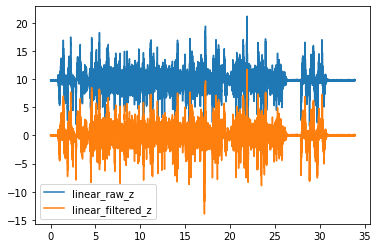

In [6]:
dt = 1.e-3 # 1 ms sampling time 

time_array = dt * np.arange(0, data['linear_raw'].shape[0]) # create a time array from 0 to the number of rows in data 

plt.figure()
plt.plot(time_array,data['linear_raw'][:,3], label='linear_raw_z')
plt.plot(time_array,data['linear_filtered'][:,3], label='linear_filtered_z')
plt.legend()

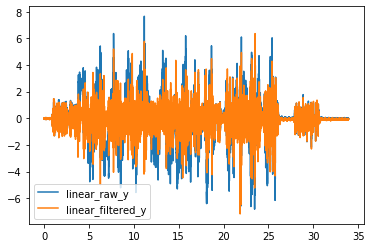

In [7]:
plt.figure()
plt.plot(time_array,data['linear_raw'][:,2], label='linear_raw_y')
plt.plot(time_array[::2],data['linear_filtered'][::2,2], label='linear_filtered_y')
plt.legend()

## Estimate the Parameters of the Model 

**so how does the model look like ?**

$\begin{bmatrix} U_x \\ U_y \\ U_z \end{bmatrix}^{measured} = \begin{bmatrix} {S_F + M_F} \end{bmatrix}\begin{bmatrix} a_x \\ a_y \\ a_z \end{bmatrix}^{actual/true} + \begin{bmatrix} b_x \\ b_y \\ b_z \end{bmatrix}^{bias} + \begin{bmatrix} \eta_x \\ \eta_y \\ \eta_z \end{bmatrix}^{random noises} $ 

\begin{equation} S_F = \begin{bmatrix} k_x & 0 & 0 \\ 0 & k_y & 0 \\ 0 & 0 & k_z \end{bmatrix}^{scale factor} \end{equation}

\begin{align*} M_F = \begin{bmatrix} 0 & m_{xy} & m_{xz} \\ m_{yx} & 0 & m_{yz} \\ m_{zx} & m_{zy} & 0 \end{bmatrix}^{misalignment} \end{align*}

\begin{equation} S_i = \frac{l_f^{up} - l_f^{down} - 2 * k}{2*k} \end{equation}

\begin{equation} b_i = \frac{l_f^{up} + l_f^{down}}{2} \\\ i = x,y,z \end{equation} 


**Least Square Method**



\begin{equation} y = mx + b \\ Y = XA + E  \end{equation} 
\begin{equation} Y = \begin{bmatrix} y_1  \\ y_2 \\ ... \\ y_n \end{bmatrix}^{ n x 1} \end{equation} 
\begin{equation} X = \begin{bmatrix} 1 & x_1  \\ 1 & x_2 \\ ... & ... \\ 1 & x_n \end{bmatrix}^{ n x 2} \end{equation} 
\begin{equation} A = \begin{bmatrix} b  \\ m  \end{bmatrix}^{ 2 x 1} \end{equation} 
\begin{equation} b = bias \\ m = scale factor  \end{equation} 

**Recurrsive Least Square**

$\begin{bmatrix} F_x & F_y & F_z \end{bmatrix}^{{T} \\ {True-value}}= \begin{bmatrix} A_F^S & A_F^M & -I_{[3x3]}\end{bmatrix}
\begin{bmatrix} s_F & m_F & B_F' \end{bmatrix}^{T} + \begin{equation} W_F \end{equation} $ 



In [8]:

Y = data['linear_raw_stat'][::2,1:]
X = data['linear_filtered_stat'][::2,1:]

m,n = X.shape 
X0 = np.ones((m,1))
Xnew = np.hstack((X0,X))

#print(Xnew)

#Xx =(np.column_stack((np.ones(np.size(X)),X)))
#print(X)

A = np.linalg.inv(Xnew.T.dot(Xnew)).dot(Xnew.T).dot(Y)
print(A)

l = len(A[0])
scale_factor_lin = [A[i][i] for i in range(l)]

print(scale_factor_lin)  






[[ 3.82941810e-02 -2.49590301e-01  9.78847048e+00]
 [ 3.25325558e-01  8.17304017e-02 -1.73290519e-01]
 [-4.63668902e-03  2.34454712e-01 -1.06165123e-01]
 [-3.92495394e-02 -6.13111490e-02  1.37619600e-01]]
[0.03829418097558765, 0.08173040169488917, -0.10616512332790629]


In [9]:
Y = data['linear_raw'][::2,1:] 
X = data['linear_filtered'][::2,1:]

m,n = X.shape 
X0 = np.ones((m,1))
Xnew = np.hstack((X0,X))

splits = 100

output_Y = np.array([sum(Y[i:i + splits])/splits
          for i in np.arange(0, len(Y), splits)])
output_X = np.array([sum(Xnew[i:i + splits])/splits
          for i in np.arange(0, len(Xnew), splits)])
#print(output_X.shape)
#print(output_Y.shape)
A = np.linalg.inv(output_X.T.dot(output_X)).dot(output_X.T).dot(output_Y)
print(A)


[[ 0.02441249  0.0894399   9.64741067]
 [ 1.63898618 -0.25330843  0.1218644 ]
 [-0.5902269   3.99519611 -0.08200026]
 [-0.22684954  0.01053475  1.01170445]]


In [10]:
Y = data['angular_raw'][::2,1:]
X = data['angular_filtered'][::2,1:]

m,n = X.shape 
X0 = np.ones((m,1))
Xnew = np.hstack((X0,X))

#print(Xnew)

#Xx =(np.column_stack((np.ones(np.size(X)),X)))
#print(X)

A = np.linalg.inv(Xnew.T.dot(Xnew)).dot(Xnew.T).dot(Y)
print(A)

l = len(A[0])
scale_factor_lin = [A[i][i] for i in range(l)]

print(scale_factor_lin)

[[-0.10990495  0.07590269  0.18219972]
 [ 0.00414823  0.00334298  0.0007081 ]
 [-0.14899438  0.07509773 -0.07324157]
 [-0.16617922  0.10548574  0.25823122]]
[-0.10990495020388749, 0.0033429769236971198, -0.07324156676096903]


In [11]:
Y = data['angular_raw'][::2,1:] 
X = data['angular_filtered'][::2,1:]

m,n = X.shape 
X0 = np.ones((m,1))
Xnew = np.hstack((X0,X))

splits = 100

output_Y = np.array([sum(Y[i:i + splits])/splits
          for i in np.arange(0, len(Y), splits)])
output_X = np.array([sum(Xnew[i:i + splits])/splits
          for i in np.arange(0, len(Xnew), splits)])
#print(output_X.shape)
#print(output_Y.shape)
A = np.linalg.inv(output_X.T.dot(output_X)).dot(output_X.T).dot(output_Y)
print(A)

[[-0.1942373  -0.03724901  0.17303743]
 [-0.00499962  0.01161792  0.00146362]
 [-0.50124106  0.08312282 -0.06472488]
 [-0.27824921 -0.06844891  0.24411483]]


In [12]:
# Checking the cumsum function !!!
inp = data['linear_filtered'][:,1]
print("Input array : ", inp)
out = np.cumsum(inp) 
print("cumulative sum : ", out)


Input array :  [0.0234375 0.0126953 0.0126953 ... 0.0795898 0.0581055 0.0581055]
cumulative sum :  [ 2.34375000e-02  3.61328000e-02  4.88281000e-02 ... -4.42496314e+02
 -4.42438208e+02 -4.42380103e+02]


In [13]:
def function(n_samples, t0, T_min, T_max, clusters):
    if T_min is None:
        min_size = 1
    else:
        min_size = int(T_min / t0)

    if T_max is None:
        max_size = int(math.floor(n_samples / 2)) 
    else:
        max_size = int(T_max / t0)
        
    result = np.logspace(np.log2(min_size), np.log2(max_size), num=clusters, base=2)
    return np.unique(np.round(result)).astype(int)
    

0.00010349936363259395


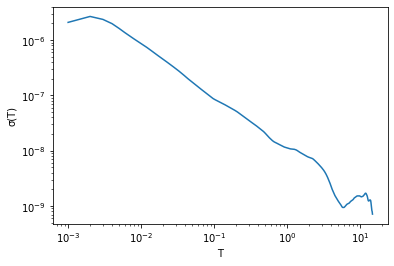

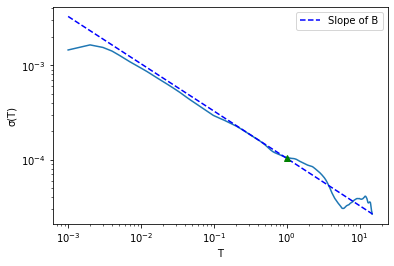

2.2370047369105116e-05


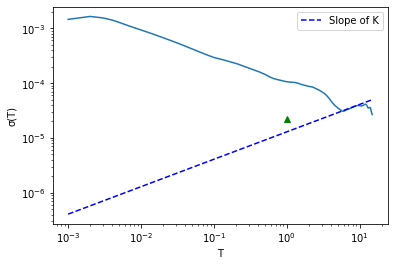

5.2674412721384115e-06
0.6644509157679996
5.866710414514631e-05


In [17]:
def al_var(x, dt=1, T_min=None, T_max=None,
                   clusters=1000, input_type='mean'):
    
    T = n*t0;

    
    x = np.asarray(x, dtype=float)
    if input_type == 'integral':
        X = x
    else:
        X = np.cumsum(x)
        #print(X.shape)
    cluster_sizes = function(len(x), t0, T_min, T_max, clusters)
    #print(cluster_sizes)    
    
    avar = np.empty(cluster_sizes.shape + X.shape[1:])
    for i, k in enumerate(cluster_sizes):
        c = X[2*k:] - 2 * X[k:-k] + X[:-2*k]
        avar[i] = np.mean(c**2, axis=0) / k / k

    if input_type == 'mean':
        avar *= 0.5
    else:
        avar *= 0.5 / t0**2
    
    
    
    return cluster_sizes * t0, avar

t0 = 1.e-3
x = data['angular_raw_stat'][:,1]  
#print(x.shape)

T, av = al_var(x, t0, input_type='mean')

plt.figure("Allan Deviation")
plt.xlabel("T")
plt.ylabel("σ(T)")
plt.loglog(T, av)

adev = np.sqrt(av)
    #print(adev)
    
slope = -0.5
logT = np.log10(T)

logadev = np.log10(adev)
dlogadev = np.diff(logadev) / np.diff(logT)
    
    
a = (abs(dlogadev - slope).tolist())
index_min = a.index(min(a))
#b = logadev(i) - slope*logtau(i);
b = logadev[index_min] - slope*logT[index_min]
logN = slope*np.log10(1) + b
#print(logN)

N = pow(10,logN)    
print(N)    # Angle Random Walk


TN = 1
lineN = np.divide(N, np.sqrt(T))
#print(lineN)
plt.figure("Fig.2")
#plt.loglog(T, av)
#plt.loglog(T, av, T, lineN , '--' , TN, N)
plt.loglog(T, adev) 
plt.loglog(T, lineN, 'b--', label='Slope of B')
plt.loglog(TN, N, 'g^')
plt.xlabel("T")
plt.ylabel("σ(T)")
plt.legend()
plt.show()
 
    
slope = 0.5
logT = np.log10(T)

logadev = np.log10(adev)
dlogadev = np.diff(logadev) / np.diff(logT)
    
    
a = (abs(dlogadev - slope).tolist())
index_min = a.index(min(a))
#b = logadev(i) - slope*logtau(i);
b = logadev[index_min] - slope*logT[index_min]

logK = slope*np.log10(3) + b
K = pow(10,logK)
print(K)    # Rate Random Walk    

TK = 3
lineK = np.multiply(K ,np.sqrt(T/3))
plt.figure("Fig.3")
plt.loglog(T, adev) 
plt.loglog(T, lineK, 'b--', label='Slope of K')
plt.loglog(TN, K, 'g^')
plt.xlabel("T")
plt.ylabel("σ(T)")
plt.legend()
plt.show()
    

slope = 1
logT = np.log10(T)

logadev = np.log10(adev)
dlogadev = np.diff(logadev) / np.diff(logT)
    
    
a = (abs(dlogadev - slope).tolist())
index_min = a.index(min(a))
#b = logadev(i) - slope*logtau(i);
b = logadev[index_min] - slope*logT[index_min]

logR = slope*np.log10(2) + b
R = pow(10,logR)
print(R)    # Rate Ramp walk   



slope = 0
logT = np.log10(T)

logadev = np.log10(adev)
dlogadev = np.diff(logadev) / np.diff(logT)
    
    
a = (abs(dlogadev - slope).tolist())
index_min = a.index(min(a))
#b = logadev(i) - slope*logtau(i);
b = logadev[index_min] - slope*logT[index_min]

scfB = np.sqrt(2*np.log(2)/3.14)
print(scfB)
logB = b - np.log10(scfB)
B = pow(10,logB)    
print(B) # Bias Noise

In [161]:


key = [1, 1, 14, 6, 1, 12, 14, 6, 6, 7, 4, 3, 7, 9, 1, 3, 3, 6, 5, 8]
dist = [3.3, 2.1, 3.5, 2.5, 4.6, 7.4, 2.6, 7.8, 9.2, 10.11, 14.3, 2.5, 6.7, 3.4, 7.5, 8.5, 9.7, 4.3, 2.8, 4.1]

for d in set(key):
    print (d, mean([dist[i] for i in range(len(key)) if key[i] == d]))
    
    

1 4.375
3 6.8999999999999995
4 14.3
5 2.8
6 5.95
7 8.405
8 4.1
9 3.4
12 7.4
14 3.05


## Final Goal of the Project

In [ ]:
def accelerometer_model(actual_linear_acc, actual_angular_vel): 
    sensor_acc = np.zeros(3)
    sensor_angular_vel = np.zeros(3)
    """ do some math here """
    
    return sensor_acc, sensor_angular_vel 